In [23]:
import numpy as np     
import tensorflow as tf # deaplearning# advanced math library
import matplotlib.pyplot as plt      # plotting routines
from keras.models import Model       # Model type to be used
from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools
import keras #deeplearning surcouche à utiliser en premier lieu sinon utiliser tensorflow ou pytorch
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset
# from torch import optim
# from torch.autograd import Variable
# from torch.nn import functional as F
from torchvision import transforms
from PIL import Image
import os
from sklearn.model_selection import train_test_split

## Ouverture des images et création des dataloaders
contenu = os.listdir('dataset/00000')
# print(contenu)
convert_tensor = transforms.ToTensor()
dataset = []
data_dir = "dataset/00000"

for i in range(len(contenu)):
    img_path = os.path.join(data_dir, contenu[i])
    img = Image.open(img_path)
    img = img.resize((64, 64))
    tensor = convert_tensor(img)
    # print(tensor.shape)
    # taille des tensor 3*64*64
    #tensor = tensor.unsqueeze(0)
    #print(tensor.shape)
    dataset.append(tensor)

# print(dataset)


X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)
X_train, X_val = train_test_split(X_train, test_size=0.25, random_state=0)

batch_size = 10

train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, num_workers = 8)
valid_loader = torch.utils.data.DataLoader(X_val, batch_size=batch_size,num_workers = 30)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=True,num_workers = 8)


# taille des images 1*3*64*64

class Encoder(torch.nn.Module):
    def __init__(self, encoded_dim):
        super(Encoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=(3, 3), stride=1, padding=0),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, padding=1),
            torch.nn.Dropout(0.2),
            torch.nn.Conv2d(64, 32, kernel_size=(3, 3), stride=1, padding=0),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, padding=1),
            torch.nn.Dropout(0.2),
            torch.nn.Conv2d(32, 16, kernel_size=(3, 3), stride=1, padding=0),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, padding=1),
            torch.nn.Dropout(0.2),
            torch.nn.Conv2d(16, 8, kernel_size=(3, 3), stride=1, padding=0),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, padding=0),
            torch.nn.Dropout(0.2))

        self.flatten = torch.nn.Flatten(start_dim=1)

        self.encoder_lin = torch.nn.Sequential(
            torch.nn.Linear(3 * 3 * 8, 128),
            torch.nn.ReLU(True),
            torch.nn.Linear(128, encoded_dim))

    def forward(self, x):
        x = self.encoder(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.encoder_lin(x)
        #print(x.shape)
        return x


class Decoder(torch.nn.Module):
    def __init__(self,encoded_dim, batch_size_ ):
        super(Decoder, self).__init__()
        self.batch_size = batch_size_
        self.decoder = torch.nn.Sequential(
            nn.Linear(encoded_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 8),
            nn.ReLU(True))

        self.decoder_next = torch.nn.Sequential(
            torch.nn.Conv2d(3, 8, kernel_size=(3, 3), stride=1, padding=1),
            torch.nn.ReLU(True),
            torch.nn.UpsamplingNearest2d(size=(8, 8)),
            torch.nn.Dropout(0.2),
            torch.nn.Conv2d(8, 16, kernel_size=(3, 3), stride=1, padding=1),
            torch.nn.ReLU(True),
            torch.nn.UpsamplingNearest2d(size=(16, 16)),
            torch.nn.Dropout(0.2),
            torch.nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding=1),
            torch.nn.ReLU(True),
            torch.nn.UpsamplingNearest2d(size=(32, 32)),
            torch.nn.Dropout(0.2),
            torch.nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1),
            torch.nn.ReLU(True),
            torch.nn.UpsamplingNearest2d(size=(64, 64)),
            torch.nn.Conv2d(64, 3, kernel_size=(3, 3), stride=1, padding=1),
            torch.nn.Sigmoid())

    def forward(self, x):
        x = self.decoder(x)
        #print(x.shape)
        x = torch.reshape(x, (self.batch_size, 3, 3, 8))
        #x = x.unsqueeze(0)
        #print(x.shape)
        x = self.decoder_next(x)
        #print(x.shape)
        return x


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = torch.nn.MSELoss()
lr = 0.001
dim = 10
torch.manual_seed(0)

encoder = Encoder(encoded_dim=dim)
decoder = Decoder(batch_size_ = batch_size,encoded_dim=dim)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
encoder.to(device)
decoder.to(device)


def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch in dataloader:  # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)


def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad():  # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data




In [37]:
num_epochs = 50
diz_loss = {'train_loss': [], 'val_loss': []}
for epoch in range(num_epochs):
    train_loss = train_epoch(encoder, decoder, device,
                             train_loader, loss_fn, optim)
    val_loss = test_epoch(encoder, decoder, device, test_loader, loss_fn)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs, train_loss, val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)


 EPOCH 1/50 	 train loss 0.06976763159036636 	 val loss 0.07090013474225998

 EPOCH 2/50 	 train loss 0.06888153403997421 	 val loss 0.07078840583562851

 EPOCH 3/50 	 train loss 0.06872956454753876 	 val loss 0.07019860297441483

 EPOCH 4/50 	 train loss 0.06710255891084671 	 val loss 0.06743183732032776

 EPOCH 5/50 	 train loss 0.0662226527929306 	 val loss 0.06698133051395416

 EPOCH 6/50 	 train loss 0.06581532210111618 	 val loss 0.06661471724510193

 EPOCH 7/50 	 train loss 0.06544257700443268 	 val loss 0.06614842265844345

 EPOCH 8/50 	 train loss 0.06521198898553848 	 val loss 0.06604859232902527

 EPOCH 9/50 	 train loss 0.06506339460611343 	 val loss 0.06592336297035217

 EPOCH 10/50 	 train loss 0.06487952917814255 	 val loss 0.06585531681776047

 EPOCH 11/50 	 train loss 0.06478536874055862 	 val loss 0.06580562889575958

 EPOCH 12/50 	 train loss 0.0647459551692009 	 val loss 0.06574151664972305

 EPOCH 13/50 	 train loss 0.06470607966184616 	 val loss 0.065729990601539

In [137]:
def plot_ae_outputs(encoder, decoder,X_test, n=10):
    plt.figure(figsize=(16, 4.5))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        img = Image.open(f"dataset/01000/0100{i}.png")
        img = img.resize((64,64))
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            img_t =convert_tensor(img)
            img_t = img_t.unsqueeze(0)
            print(img_t.shape)
            rec_img = decoder(encoder(img_t))
        plt.imshow(img, cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        print(rec_img.shape)
        plt.imshow(rec_img[0].T , cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Reconstructed images')
    plt.show()

torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])


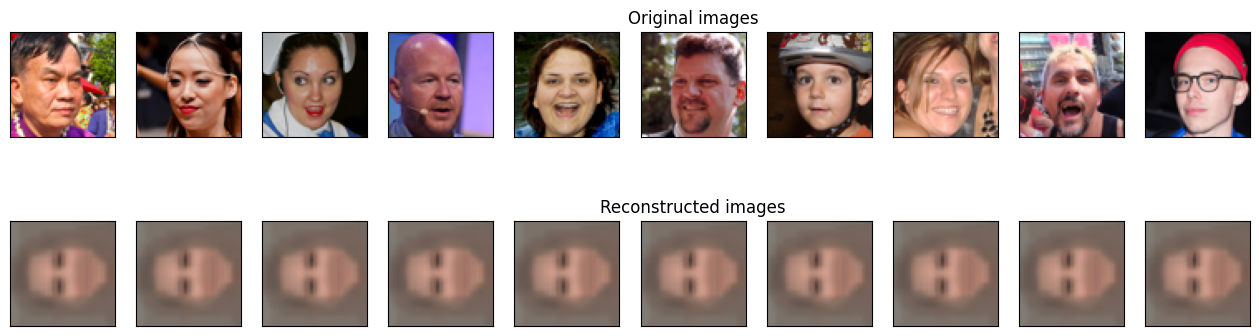

In [138]:
plot_ae_outputs(encoder, decoder,X_test, n=10)